In [1]:
import sys
sys.path.append("../")

from part_assembly import Stage1NormalDataset

In [2]:
dataset = Stage1NormalDataset()

Processing...
/opt/conda/envs/spt/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [2]:
import torch

datafolder = "/data/wlsgur4011/DataCollection/BreakingBad/data_split/"
artifact_val = f"{datafolder}artifact.train.pth"
dataset = torch.load(artifact_val)

In [2]:
for data in dataset:
    if len(data["file_names"]) <= 3:
        break

In [3]:
import jhutil; jhutil.jhprint(1111, data)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
1111  {
    "pcs": null,
    "broken_pcs": [
        "tensor[24933, 3] n=74799 (0.3Mb) x∈[-1.541, 1.253] μ=4.442e-08 σ=0.525",
        "tensor[10924, 3] n=32772 (0.1Mb) x∈[-0.926, 0.986] μ=-1.400e-08 σ=0.405",
        "tensor[14142, 3] n=42426 (0.2Mb) x∈[-1.324, 1.306] μ=-7.903e-08 σ=0.461"
    ],
    "quat": [
        "array[4] x∈[-0.461, 0.887] μ=0.119 σ=0.486 [0.014, 0.887, 0.037, -0.461]",
        "array[4] x∈[-0.690, 0.705] μ=-0.028 σ=0.499 [0.705, 0.038, -0.163, -0.690]",
        "array[4] x∈[-0.573, 0.814] μ=0.033 σ=0.499 [0.814, -0.100, -0.573, -0.009]"
    ],
    "trans": [
        "tensor[3] x∈[-1.106, 2.719] μ=0.575 σ=1.954 [-1.106, 0.112, 2.719]",
        "tensor[3] x∈[-1.554, 2.661] μ=0.524 σ=2.108 [-1.554, 0.466, 2.661]",
        "tensor[3] x∈[-0.767, 2.760] μ=0.612 σ=1.884 [-0.767, -0.156, 2.760]"
    ],


In [4]:
import os
from pytorch3d.io import load_objs_as_meshes, load_obj
meshes = load_objs_as_meshes([os.path.join(data["dir_name"], file_name) for file_name in data["file_names"]], device="cuda:0")

/opt/conda/envs/assembly/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [5]:
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    OrthographicCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    HardFlatShader,
    SoftSilhouetteShader,
    TexturesUV,
    TexturesVertex,
    MeshRendererWithFragments,
)

In [6]:
from pytorch3d.renderer.mesh.shader import NormalShader

In [13]:
from random import randint
randint(0, 1)

0

In [7]:
device = "cuda:0"
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(1, 31, 180)

cameras = FoVPerspectiveCameras(device=device, R=R, T=T) #, focal_length=1)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRendererWithFragments(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=NormalShader(
        # device=device, 
        # cameras=cameras,
        # lights=lights
    )
)

# fragment = Fragments()
images, fragment = renderer(meshes)
images = images.squeeze()


import jhutil; jhutil.jhprint(1111, images)

1111  "tensor[3, 512, 512, 3] n=2359296 (9Mb) x∈[-1.000, 1.000] μ=0.014 σ=0.180 cuda:0"


In [8]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [9]:
is_broken_face = data["is_broken_face"]
fragment.pix_to_face

tensor[3, 512, 512, 1] i64 n=786432 (6Mb) x∈[-1, 27821] μ=1.278e+03 σ=4.529e+03 cuda:0

In [23]:
import torch

idx = 1

x = fragment.pix_to_face[idx].cpu()
list = torch.nonzero(is_broken_face[idx].cpu()).squeeze() + 23910

# First, reshape the tensors to make them broadcastable
x_reshaped = x.reshape(-1, 1)  # size will be (b*h*w*c, 1)
list_reshaped = list.reshape(1, -1)  # size will be (1, l)

# Then, we do an equality check. This will be a tensor of the same shape as the reshaped x,
# with True where the element of x is in list, and False otherwise.
isin = (x_reshaped == list_reshaped)

# This line reduces along the second dimension (i.e., it checks if there are any True values along the second dimension, which corresponds to the list dimension).

import jhutil; jhutil.jhprint(1111, isin)
isin = isin.any(dim=-1)
import jhutil; jhutil.jhprint(3333, isin)

# Now we just reshape it back to the original x shape.
isin = isin.reshape(x.shape)

import jhutil; jhutil.jhprint(5555, isin)

from einops import rearrange, repeat

tmp = repeat(isin.float().squeeze(), 'h w -> c h w', c=3)  
image = rearrange(images.abs(), 'b h w c -> b c h w')[idx]


1111  "tensor[262144, 168] bool n=44040192 (42Mb) x∈[False, True] μ=3.006e-05 σ=0.005"
3333  "tensor[262144] bool 0.2Mb x∈[False, True] μ=0.005 σ=0.071"
5555  "tensor[512, 512, 1] bool n=262144 (0.2Mb) x∈[False, True] μ=0.005 σ=0.071"


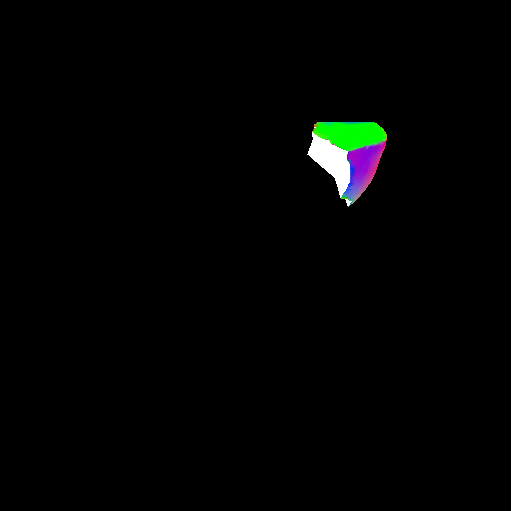

In [26]:
(image.cpu() + tmp.cpu()).rgb

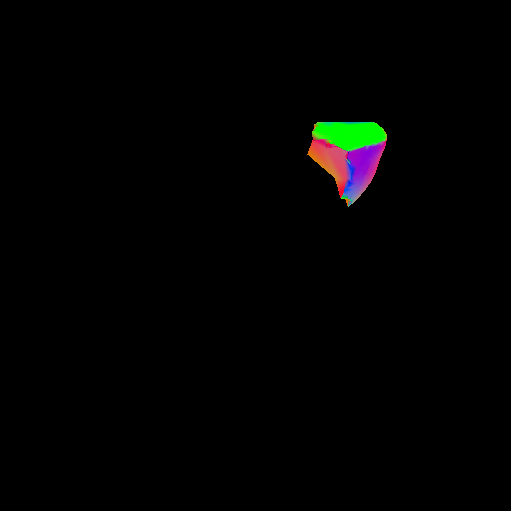

In [27]:
image.rgb

In [12]:
x, list

(tensor[512, 512, 1] i64 n=262144 (2Mb) x∈[-1, 23861] μ=2.867e+03 σ=5.740e+03,
 tensor[444] i64 3.5Kb x∈[0, 11346] μ=2.980e+03 σ=3.848e+03)

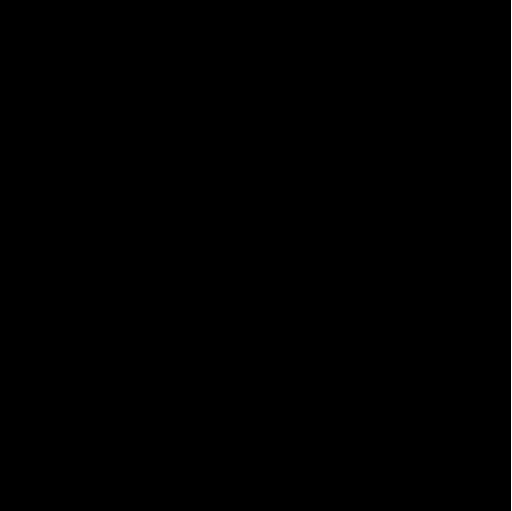

In [14]:
23910 + 1848 + 2092


27850

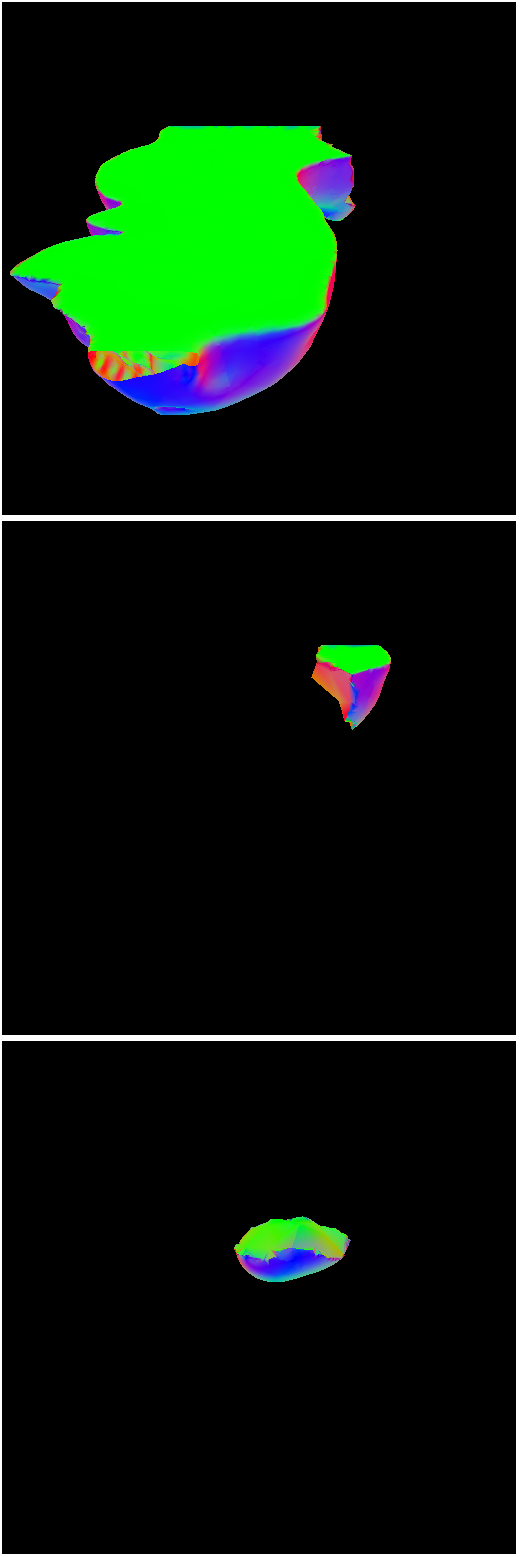

In [57]:

from einops import rearrange, repeat

rearrange(images.abs(), 'b h w c -> b c h w').rgb(scale=1)

In [60]:
face_img = fragment.pix_to_face.squeeze().float()
face_img[face_img > 0] = face_img[face_img > 0] / face_img.max()

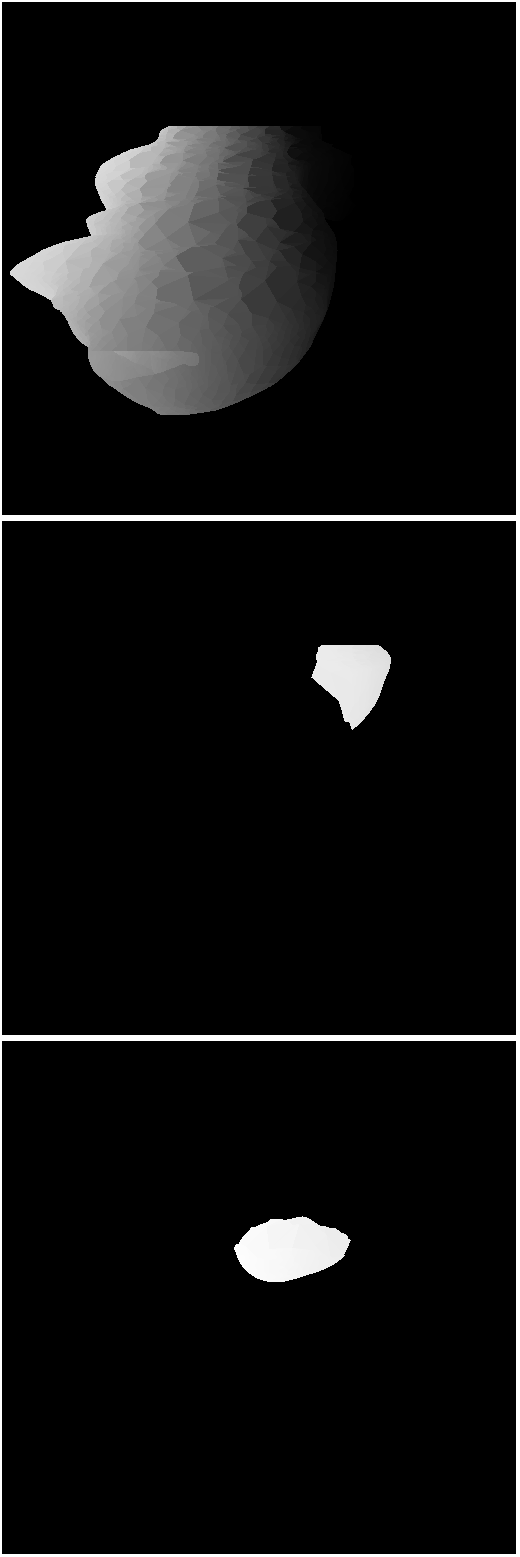

In [61]:
repeat(face_img, 'b h w -> b repeat h w', repeat=3).rgb


In [65]:
data["is_broken_vertices"]

[tensor[11957] bool 12Kb x∈[False, True] μ=0.032 σ=0.177,
 tensor[926] bool x∈[False, True] μ=0.157 σ=0.364,
 tensor[1048] bool 1.0Kb x∈[False, True] μ=0.240 σ=0.428]